# MaskRCNN

In [1]:
# https://mmdeploy.readthedocs.io/en/latest/get_started.html#convert-model
! python mmdeploy/tools/deploy.py \
mmdeploy/configs/mmdet/instance-seg/instance-seg_onnxruntime_dynamic.py \
mmdetection/configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py \
checkpoints/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth \
mmdetection/demo/demo.jpg \
--work-dir onnx_models \
--device cpu \
--dump-info

[2022-06-26 13:24:18.512] [mmdeploy] [info] [model.cpp:95] Register 'DirectoryModel'
[2022-06-26 13:24:19.988] [mmdeploy] [info] [model.cpp:95] Register 'DirectoryModel'
/root/workspace/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
[2022-06-26 13:24:28.347] [mmdeploy] [info] [model.cpp:95] Register 'DirectoryModel'
2022-06-26 13:24:28,352 - mmdeploy - INFO - Start pipeline mmdeploy.apis.pytorch2onnx.torch2onnx in subprocess
load checkpoint from local path: checkpoints/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth
/root/workspace/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data 

# PanopticFPN

## ONNX Runtime backend (static)

In [2]:
! python mmdeploy/tools/deploy.py \
mmdeploy/configs/mmdet/panoptic-seg/panoptic-seg_onnxruntime_static.py \
mmdetection/configs/panoptic_fpn/panoptic_fpn_r50_fpn_1x_coco.py \
checkpoints/panoptic_fpn_r50_fpn_1x_coco_20210821_101153-9668fd13.pth \
mmdetection/demo/demo.jpg \
--test-img mmdetection/demo/demo.jpg \
--work-dir onnx_models \
--device cpu \
--dump-info

[2022-06-26 13:24:59.778] [mmdeploy] [info] [model.cpp:95] Register 'DirectoryModel'
[2022-06-26 13:25:01.307] [mmdeploy] [info] [model.cpp:95] Register 'DirectoryModel'
/root/workspace/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
[2022-06-26 13:25:08.815] [mmdeploy] [info] [model.cpp:95] Register 'DirectoryModel'
2022-06-26 13:25:08,821 - mmdeploy - INFO - Start pipeline mmdeploy.apis.pytorch2onnx.torch2onnx in subprocess
/root/workspace/mmdetection/mmdet/models/losses/cross_entropy_loss.py:240: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if yo

## ONNX Runtime backend (dynamic)

In [3]:
! python mmdeploy/tools/deploy.py \
mmdeploy/configs/mmdet/panoptic-seg/panoptic-seg_onnxruntime_dynamic.py \
mmdetection/configs/panoptic_fpn/panoptic_fpn_r50_fpn_1x_coco.py \
checkpoints/panoptic_fpn_r50_fpn_1x_coco_20210821_101153-9668fd13.pth \
mmdetection/demo/demo.jpg \
--test-img mmdetection/demo/demo.jpg \
--work-dir onnx_models \
--device cpu \
--dump-info

[2022-06-26 13:25:39.000] [mmdeploy] [info] [model.cpp:95] Register 'DirectoryModel'
[2022-06-26 13:25:40.524] [mmdeploy] [info] [model.cpp:95] Register 'DirectoryModel'
/root/workspace/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
[2022-06-26 13:25:47.985] [mmdeploy] [info] [model.cpp:95] Register 'DirectoryModel'
2022-06-26 13:25:47,990 - mmdeploy - INFO - Start pipeline mmdeploy.apis.pytorch2onnx.torch2onnx in subprocess
/root/workspace/mmdetection/mmdet/models/losses/cross_entropy_loss.py:240: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if yo

# Inference

In [4]:
import os
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import onnxruntime as ort

import mmcv
from mmdet.datasets.coco_panoptic import CocoPanopticDataset
from mmdet.core.visualization import imshow_det_bboxes

from mmdeploy.utils import get_input_shape, load_config
from mmdeploy.apis.utils import build_task_processor

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model_cfg='mmdetection/configs/panoptic_fpn/panoptic_fpn_r50_fpn_1x_coco.py'
deploy_cfg='mmdeploy/configs/mmdet/panoptic-seg/panoptic-seg_onnxruntime_dynamic.py'
backend_files=['onnx_models/end2end.onnx']
img='mmdetection/demo/demo.jpg'
device='cpu'

In [6]:
deploy_cfg, model_cfg = load_config(deploy_cfg, model_cfg)
task_processor = build_task_processor(model_cfg, deploy_cfg, device)

# model = task_processor.init_backend_model(backend_files)
sess = ort.InferenceSession(backend_files[0])

input_shape = get_input_shape(deploy_cfg)
model_inputs, _ = task_processor.create_input(img, input_shape)

model_inputs

/root/workspace/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


{'img_metas': [[{'filename': 'mmdetection/demo/demo.jpg',
    'ori_filename': 'mmdetection/demo/demo.jpg',
    'ori_shape': (427, 640, 3),
    'img_shape': (800, 1199, 3),
    'pad_shape': (800, 1216, 3),
    'scale_factor': array([1.8734375, 1.8735363, 1.8734375, 1.8735363], dtype=float32),
    'flip': False,
    'flip_direction': None,
    'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32),
     'std': array([58.395, 57.12 , 57.375], dtype=float32),
     'to_rgb': True}}]],
 'img': [tensor([[[[-1.8439, -1.7925, -1.7240,  ...,  0.0000,  0.0000,  0.0000],
            [-1.7754, -1.7412, -1.7069,  ...,  0.0000,  0.0000,  0.0000],
            [-1.6384, -1.6555, -1.6898,  ...,  0.0000,  0.0000,  0.0000],
            ...,
            [-1.0733, -1.1247, -1.2103,  ...,  0.0000,  0.0000,  0.0000],
            [-1.0390, -0.9877, -0.9020,  ...,  0.0000,  0.0000,  0.0000],
            [-1.0219, -0.9192, -0.7308,  ...,  0.0000,  0.0000,  0.0000]],
  
           [[-1.1429, -

In [7]:
image = model_inputs['img'][0].detach().numpy()

results = sess.run(None, {'input': image})

for out in results:
    print(out.shape)

(1, 62, 5)
(1, 62)
(1, 62, 28, 28)
(1, 54, 800, 1216)


## Postprocess & Visualize

In [8]:
image = np.transpose(image[0], (1, 2, 0))
# ignore batch dimension    
bboxes, labels, masks, semseg = map(lambda x: x[0], results)

In [9]:
from mmdet.models.roi_heads.mask_heads.fcn_mask_head import _do_paste_mask

h, w, _ = image.shape

masks, _ = _do_paste_mask(
    torch.from_numpy(masks).unsqueeze(1), 
    torch.from_numpy(bboxes[:, :4]),
    h, w,
    skip_empty=False
)

masks = masks.detach().numpy()
masks.shape

(62, 800, 1216)

In [10]:
meta = model_inputs['img_metas'][0][0]

scale_factor = np.array([*meta['scale_factor'], 1])
bboxes = bboxes/scale_factor[np.newaxis]

h_ori, w_ori, _ = meta['ori_shape']
h_img, w_img, _ = meta['img_shape']
h_pad, w_pad, _ = meta['img_shape']

masks = masks[:, :h_img, :w_img]
masks = F.interpolate(torch.from_numpy(masks[None]), 
                      size=(h_ori, w_ori), mode='bilinear', align_corners=False)
masks = masks.detach().numpy()[0]
masks = masks > 0.5

semseg = semseg[:, :h_img, :w_img]
semseg = F.interpolate(torch.from_numpy(semseg[None]),
                       size=(h_ori, w_ori), mode='bilinear', align_corners=False)
semseg = semseg.detach().numpy()[0]
segment = np.argmax(semseg, axis=0)

bboxes.shape, masks.shape, segment.shape

((62, 5), (62, 427, 640), (427, 640))

In [11]:
def show_panoptic_seg(
    image: np.ndarray,
    bboxes: np.ndarray,  # (n, 4or5), n = num bboxes
    labels: np.ndarray,  # (n)
    masks: np.ndarray,   # (n, h, w)
    segment: np.ndarray, # (h, w)
    class_names: list,
    score_thr: float,
    out_file: str = None,
    show: bool = True) -> None:
    visualized = imshow_det_bboxes(
        img=img,
        bboxes=bboxes,
        labels=labels,
        segms=masks,
        class_names=class_names,
        score_thr=0.5,
        out_file=None,
        show=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10), tight_layout=True)

    ax1.set_title('instance segmentation')
    ax1.axis('off')
    ax1.imshow(visualized[:, :, ::-1]) # BGR->RGB

    ax2.set_title('semantic segmentation')
    ax2.axis('off')
    ax2.imshow(segment)
    
    if out_file:
        plt.savefig(out_file, bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()
    plt.close()

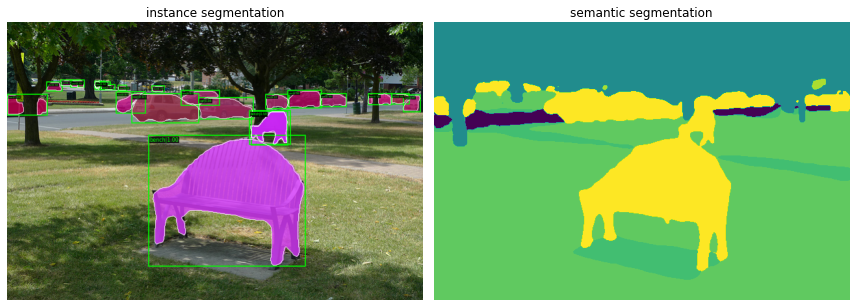

In [12]:
show_panoptic_seg(
    image=image,
    bboxes=bboxes,
    labels=labels,
    masks=masks,
    segment=np.argmax(semseg, axis=0),
    class_names=CocoPanopticDataset.CLASSES,
    score_thr=0.5,
    out_file=None,
    show=True
)